# Camera Calibration

Import the libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import os

## Number of intern corners

In [36]:
pattern_size = (4,3)

objp = np.zeros((pattern_size[0]*pattern_size[1],3),np.float32) # We create a 3D point for each corner in the chessboard
objp[:,:2] = np.mgrid[0:pattern_size[0],0:pattern_size[1]].T.reshape(-1,2) # We fill the 3D points with the 2D points of the chessboard


# Arrays to store the object points and image points from all the images
objpoints = [] # 3D point in real world space
imgpoints = [] # 2D points in image plane

# Loading the images
# Get the current working directory
baseFolder = os.getcwd()

# Select the path that contains the photos
# folder = os.path.join(baseFolder, "photos","calibration")
#folder = os.path.join(baseFolder, "FINAL_PHOTOS","CALIBRATION_25_MM")
folder = os.path.join(baseFolder, "FINAL_PHOTOS","CALIBRATION_FOLDING_LINES")

# We read all the images in the folder with png extension
images = glob.glob(os.path.join(folder, "*.png"))

print(f"Number of images found for doing the calibration: {len(images)}")

for fname in images:
    img = cv.imread(fname, 0) # We read the image in B/W
    
    ret, corners = cv.findChessboardCorners(img, pattern_size, None) # We search for the chessboard corners

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # We create a copy of the image to draw the corners in color
        img_color = img.copy()
        img_color = cv.cvtColor(img_color, cv.COLOR_GRAY2BGR)

        # We draw the chessboard corners in the image (GBR)
        for corner in corners:
            x, y = corner.ravel()
            cv.circle(img_color, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)

        # We resize the image to show it in the PC screen
        img_shown = cv.resize(img_color, (800, 600))

        # The image with the corners is shown
        cv.imshow('Detected Corners', img_shown) # We show the found corners in the image
        cv.waitKey(1000)
    else:
        print(f"The image: {fname} cannot be used for calibration, corners not found")
cv.destroyAllWindows()


ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)

print("Mean RMSE: \n", ret)
print("Camera Matrix:\n", mtx)
print("Distorsion Coefficients:\n", dist)

Number of images found for doing the calibration: 30
Mean RMSE: 
 0.24754961828915206
Camera Matrix:
 [[2.18131663e+03 0.00000000e+00 9.77436377e+02]
 [0.00000000e+00 2.18304864e+03 6.14496516e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distorsion Coefficients:
 [[-0.10707865  0.33448389 -0.00145268 -0.00147244  0.13493946]]


## Resolution Finding

We define the size of the squares of the pattern that we used for calibration purposes

In [37]:
# Size of the chessboard square in mm
square_size_mm = 24.0 # mm

# We define the resolution folder
res_folder = os.path.join(folder, "RESOLUTION")

# We read all the images in the folder with png extension
res_img = glob.glob(os.path.join(res_folder, "*.png"))

# Number of photos
print(f"Number of images found for doing the calibration: {len(res_img)}")


# We create an array to store the distance in pixels between the corners
pointDistance_px = []

for fname in res_img:
    # We read the image in B/W
    res_img = cv.imread(fname, 0)

    # We undistort the image using the camera matrix and distortion coefficients
    res_img = cv.undistort(res_img, mtx, dist)
    
    # We search for the chessboard corners
    ret_res, corners_res = cv.findChessboardCorners(res_img, pattern_size)

    if ret_res == True:
        objpoints.append(objp)
        imgpoints.append(corners_res)

        # Draw the corners on the image
        cv.drawChessboardCorners(res_img, pattern_size, corners_res, ret_res)

        img_res_shown = cv.resize(res_img, (800, 600))
        cv.imshow('Esquinas detectadas', img_res_shown)
        cv.waitKey(1000)
        cv.destroyAllWindows()

        # We take the first and last corner of the chessboard
        p1 = corners_res[0][0]  # First corner
        p2 = corners_res[3][0]  # Last corner after 3 squares (4 corners)

        # We calculate the distance in pixels between those two corners and we store it
        pointDistance_px.append(np.linalg.norm(p2 - p1))
    else:
        print(f"The image: {fname} cannot be used for calibration, corners not found")
cv.destroyAllWindows()

# We calculate the mean distance in pixels between the corners
pixel_distance = np.mean(pointDistance_px)
# Distance in mm between the corners
real_distance_mm = 3 * square_size_mm
# We find the resolution in mm/px
resolution_mm_per_px = real_distance_mm / pixel_distance

print(f"Distancia en píxeles: {pixel_distance:.2f}")
print(f"Resolución (mm/px): {resolution_mm_per_px:.4f}")

Number of images found for doing the calibration: 15
Distancia en píxeles: 326.45
Resolución (mm/px): 0.2206


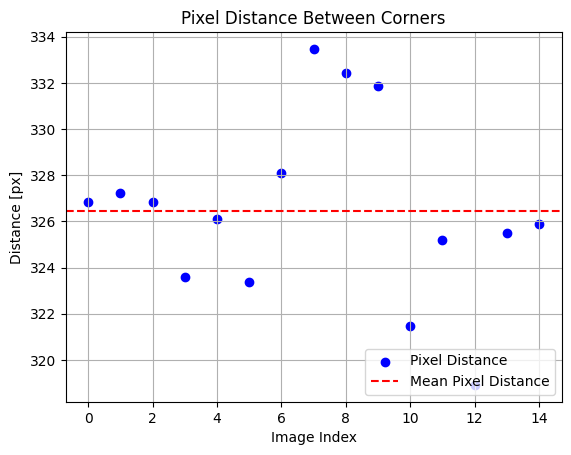

In [38]:
# We create a plot to show the results
plt.scatter(range(len(pointDistance_px)), pointDistance_px, color='blue', label='Pixel Distance')
plt.axhline(y=pixel_distance, color='red', linestyle='--', label='Mean Pixel Distance')
plt.title('Pixel Distance Between Corners')
plt.xlabel('Image Index')
plt.ylabel('Distance [px]')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

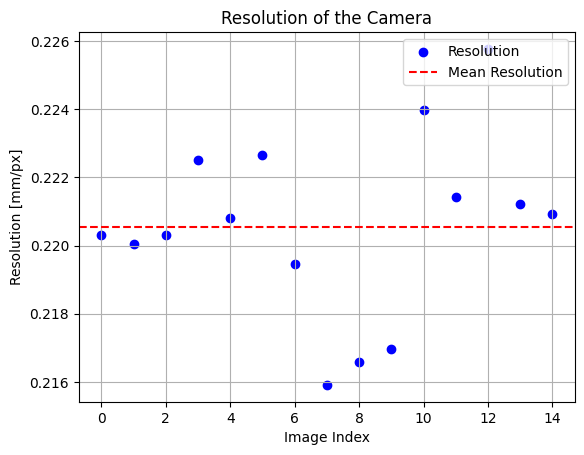

In [39]:
# We create a plot to show the results
plt.scatter(range(len(pointDistance_px)), 3*square_size_mm/np.array(pointDistance_px), color='blue', label='Resolution')
plt.axhline(y= 3*square_size_mm/pixel_distance, color='red', linestyle='--', label='Mean Resolution')
plt.title('Resolution of the Camera')
plt.xlabel('Image Index')
plt.ylabel('Resolution [mm/px]')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [40]:
#np.savez('calibration/camera_setup1.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs, res=resolution_mm_per_px)
#np.savez('calibration/camera_setup2.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs, res=resolution_mm_per_px)
#np.savez('calibration/camera_lens_25mm.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs, res=resolution_mm_per_px)
np.savez('calibration/camera_lens_12mm.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs, res=resolution_mm_per_px)